# Supervised classification of anatomy on orthopedic X-ray data

In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import data, exposure
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import numpy as np
import os
from matplotlib import pyplot as plt
from skimage import exposure
from skimage.filters import rank
from skimage.morphology import disk

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')

## Class Imbalance for only

In [3]:
base_dir = '/kaggle/input/muradatafull/MURA-v1.1a/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

labels = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']

print("Train set:\n========================================")
num_XR_ELBOW = len(os.listdir(os.path.join(train_dir, 'XR_ELBOW')))
num_XR_FINGER = len(os.listdir(os.path.join(train_dir, 'XR_FINGER')))
num_XR_FOREARM = len(os.listdir(os.path.join(train_dir, 'XR_FOREARM')))
num_XR_HAND = len(os.listdir(os.path.join(train_dir, 'XR_HAND')))
num_XR_HUMERUS = len(os.listdir(os.path.join(train_dir, 'XR_HUMERUS')))
num_XR_SHOULDER = len(os.listdir(os.path.join(train_dir, 'XR_SHOULDER')))
num_XR_WRIST = len(os.listdir(os.path.join(train_dir, 'XR_WRIST')))
print(f"XR_ELBOW={num_XR_ELBOW}")
print(f"XR_XR_FINGER={num_XR_FINGER}")
print(f"XR_FOREARM={num_XR_FOREARM}")
print(f"XR_XR_HAND={num_XR_HAND}")
print(f"XR_HUMERUS={num_XR_HUMERUS}")
print(f"XR_XR_SHOULDER={num_XR_SHOULDER}")
print(f"XR_XR_WRIST={num_XR_WRIST}")

print("Valid set:\n========================================")
print(f"XR_ELBOW={len(os.listdir(os.path.join(validation_dir, 'XR_ELBOW')))}")
print(f"XR_XR_FINGER={len(os.listdir(os.path.join(validation_dir, 'XR_FINGER')))}")
print(f"XR_FOREARM={len(os.listdir(os.path.join(validation_dir, 'XR_FOREARM')))}")
print(f"XR_XR_HAND={len(os.listdir(os.path.join(validation_dir, 'XR_HAND')))}")
print(f"XR_HUMERUS={len(os.listdir(os.path.join(validation_dir, 'XR_HUMERUS')))}")
print(f"XR_XR_SHOULDER={len(os.listdir(os.path.join(validation_dir, 'XR_SHOULDER')))}")
print(f"XR_XR_WRIST={len(os.listdir(os.path.join(validation_dir, 'XR_WRIST')))}")


weight_for_num_XR_ELBOW = num_XR_ELBOW / (num_XR_ELBOW + num_XR_FINGER + num_XR_FOREARM + num_XR_HAND + num_XR_HUMERUS + num_XR_SHOULDER + num_XR_ELBOW)
weight_for_num_XR_FINGER = num_XR_FINGER / (num_XR_ELBOW + num_XR_FINGER + num_XR_FOREARM + num_XR_HAND + num_XR_HUMERUS + num_XR_SHOULDER + num_XR_ELBOW)
weight_for_num_XR_FOREARM= num_XR_FOREARM / (num_XR_ELBOW + num_XR_FINGER + num_XR_FOREARM + num_XR_HAND + num_XR_HUMERUS + num_XR_SHOULDER + num_XR_ELBOW)
weight_for_num_XR_HAND = num_XR_HAND / (num_XR_ELBOW + num_XR_FINGER + num_XR_FOREARM + num_XR_HAND + num_XR_HUMERUS + num_XR_SHOULDER + num_XR_ELBOW)
weight_for_num_XR_HUMERUS = num_XR_HUMERUS / (num_XR_ELBOW + num_XR_FINGER + num_XR_FOREARM + num_XR_HAND + num_XR_HUMERUS + num_XR_SHOULDER + num_XR_ELBOW)
weight_for_num_XR_SHOULDER = num_XR_SHOULDER / (num_XR_ELBOW + num_XR_FINGER + num_XR_FOREARM + num_XR_HAND + num_XR_HUMERUS + num_XR_SHOULDER + num_XR_ELBOW)
weight_for_num_XR_WRIST = num_XR_WRIST / (num_XR_ELBOW + num_XR_FINGER + num_XR_FOREARM + num_XR_HAND + num_XR_HUMERUS + num_XR_SHOULDER + num_XR_ELBOW)



class_weight = {0: weight_for_num_XR_ELBOW,
                1: weight_for_num_XR_FINGER,
                2: weight_for_num_XR_FOREARM,
                3: weight_for_num_XR_HAND,
                4:weight_for_num_XR_HUMERUS,
                5: weight_for_num_XR_SHOULDER,
                6: weight_for_num_XR_WRIST,
                }

print(f"Weight for class weight_for_num_XR_ELBOW: {weight_for_num_XR_ELBOW:.2f}")
print(f"Weight for class weight_for_num_XR_FINGER: {weight_for_num_XR_FINGER:.2f}")
print(f"Weight for class weight_for_num_XR_FOREARM: {weight_for_num_XR_FOREARM:.2f}")
print(f"Weight for class weight_for_num_XR_HAND: {weight_for_num_XR_HAND:.2f}")
print(f"Weight for class weight_for_num_XR_HUMERUS: {weight_for_num_XR_HUMERUS:.2f}")
print(f"Weight for class weight_for_num_XR_SHOULDER: {weight_for_num_XR_SHOULDER:.2f}")
print(f"Weight for class weight_for_num_XR_WRIST: {weight_for_num_XR_WRIST:.2f}")

Train set:
XR_ELBOW=1714
XR_XR_FINGER=1868
XR_FOREARM=868
XR_XR_HAND=1948
XR_HUMERUS=590
XR_XR_SHOULDER=2697
XR_XR_WRIST=3270
Valid set:
XR_ELBOW=155
XR_XR_FINGER=169
XR_FOREARM=132
XR_XR_HAND=162
XR_HUMERUS=135
XR_XR_SHOULDER=176
XR_XR_WRIST=210
Weight for class weight_for_num_XR_ELBOW: 0.15
Weight for class weight_for_num_XR_FINGER: 0.16
Weight for class weight_for_num_XR_FOREARM: 0.08
Weight for class weight_for_num_XR_HAND: 0.17
Weight for class weight_for_num_XR_HUMERUS: 0.05
Weight for class weight_for_num_XR_SHOULDER: 0.24
Weight for class weight_for_num_XR_WRIST: 0.29


### Implemented Densenet

In [4]:
with strategy.scope():
    def H(inputs, num_filters, dropout_rate):

        x = tf.keras.layers.BatchNormalization(epsilon=eps)(inputs)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.ZeroPadding2D((1, 1))(x)
        x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), use_bias=False, kernel_initializer='he_normal')(x)
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
        return x


    def transition(inputs, num_filters, compression_factor, dropout_rate):
        # compression_factor is the 'θ'
        x = tf.keras.layers.BatchNormalization(epsilon=eps)(inputs)
        x = tf.keras.layers.Activation('relu')(x)
        num_feature_maps = inputs.shape[1]  # The value of 'm'

        x = tf.keras.layers.Conv2D(np.floor(compression_factor * num_feature_maps).astype(np.int),
                                   kernel_size=(1, 1), use_bias=False, padding='same', kernel_initializer='he_normal',
                                   kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ))(x)
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)

        x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
        return x


    def dense_block(inputs, num_layers, num_filters, growth_rate, dropout_rate):
        for i in range(num_layers):  # num_layers is the value of 'l'
            conv_outputs = H(inputs, num_filters, dropout_rate)
            inputs = tf.keras.layers.Concatenate()([conv_outputs, inputs])
            num_filters += growth_rate  # To increase the number of filters for each layer.
        return inputs, num_filters


    input_shape = (224, 224, 3)
    num_blocks = 3
    num_layers_per_block = 4
    growth_rate = 16
    dropout_rate = 0.05
    compress_factor = 0.5
    eps = 1.1e-5

    num_filters = 16

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), use_bias=False, kernel_initializer='he_normal',
                               kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ))(inputs)

    for i in range(num_blocks):
        x, num_filters = dense_block(x, num_layers_per_block, num_filters, growth_rate, dropout_rate)
        x = transition(x, num_filters, compress_factor, dropout_rate)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(7)(x)
    outputs = tf.keras.layers.Activation('softmax')(x)
    model = tf.keras.models.Model(inputs, outputs)
    model.summary()
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3, mode='min')
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr=0.0007),
                  metrics=['categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 222, 222, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 222, 222, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Normal Convolution network

In [5]:
with strategy.scope():
model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The third convolution
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')

### Pre train densenet

In [6]:
with strategy.scope():
    vgg16 = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet',
    input_shape=(224, 224, 3), pooling=None, classes=7,
    classifier_activation='softmax'
    )
    
    for layer in vgg16.layers:
        layer.trainable = False
    x = tf.keras.layers.Flatten()(vgg16.output)
    x = tf.keras.layers.Dense(7, activation = 'softmax')(x) 
    model = tf.keras.models.Model(inputs = vgg16.input, outputs = x)
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr=0.0007),
                  metrics=['categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])  

58892288/58889256 [==============================] - 1s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

### Pre train densenet

In [7]:
  with strategy.scope():
    model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    x = model_d.output
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.5)(x)

    preds = Dense(8, activation='softmax')(x)  # FC-layer

## Training Generater and complite model 

In [8]:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    # zca_whitening = True,
    fill_mode='nearest',
    shear_range=0.3,
    samplewise_center = True,
    # samplewise_std_normalization=True
    featurewise_std_normalization= False,
    samplewise_std_normalization=True

)
test_datagen = ImageDataGenerator(rescale=1. / 255,
                    # preprocessing_function=equalization,
                  # horizontal_flip = True,
                  # zoom_range = 0.0,
                    shear_range=0.3,
                  fill_mode='nearest',
                  featurewise_std_normalization=False,
                  samplewise_std_normalization=True,
                  samplewise_center =True                                  )
batch_size = 8
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # This is the source directory for training images
    target_size=(224, 224),  # All images will be resized to 150x150
    batch_size=batch_size,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='categorical',shuffle=False)
print("train_generator", train_generator.total_batches_seen)
# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',shuffle=False)


Found 12934 images belonging to 7 classes.
train_generator 0
Found 1118 images belonging to 7 classes.


## Setting seeds for reproducibility

In [9]:
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

### Agumented Image

train_generator.classes [0 0 0 ... 6 6 6]
train_generator.indice {'XR_ELBOW': 0, 'XR_FINGER': 1, 'XR_FOREARM': 2, 'XR_HAND': 3, 'XR_HUMERUS': 4, 'XR_SHOULDER': 5, 'XR_WRIST': 6}


/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


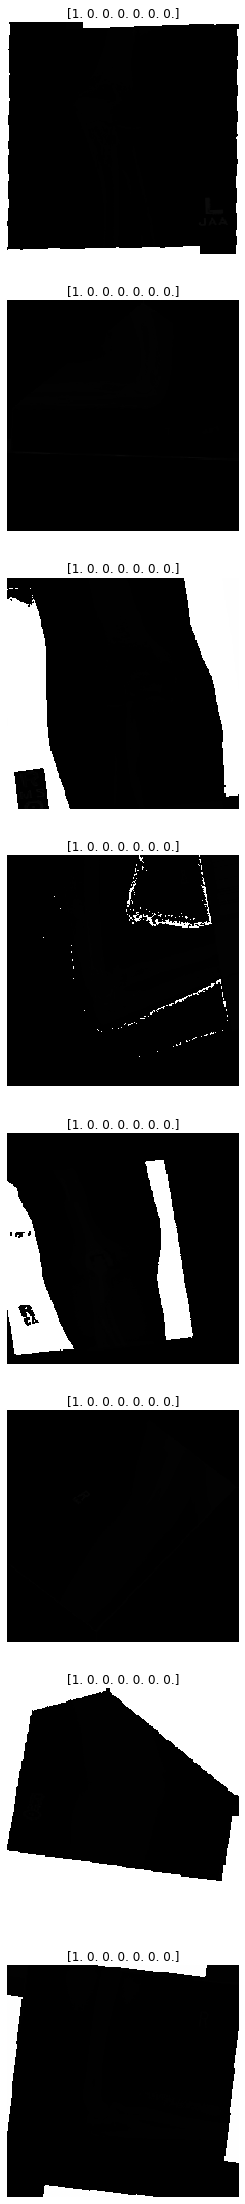

<Figure size 432x288 with 0 Axes>

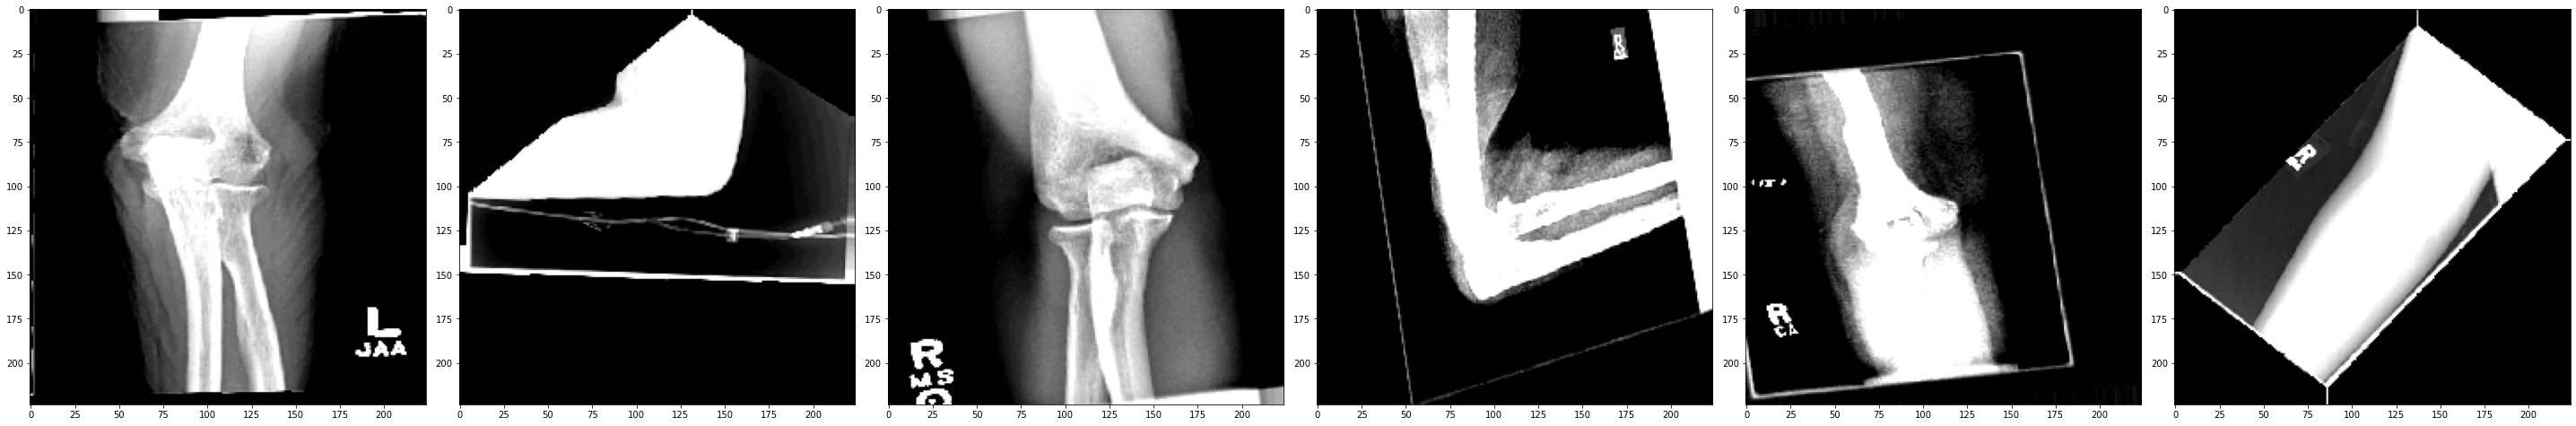

This is the label 
 [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [10]:
def plotImages(images_arr):
    plt.figure()
    fig, axes = plt.subplots(1,6, figsize=(40,40))

    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

import numpy as np
def plots(ims, figsize=(40,40), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1

    for i in range(len(ims)):
        sp = f.add_subplot(cols, rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
#Check the training set (with batch of 10 as defined above
imgs, labels = next(train_generator)
print("train_generator.classes",train_generator.classes)
print("train_generator.indice",train_generator.class_indices)
#Images are shown in the output
plots(imgs, titles=labels)

augmented_images = [train_generator[1][1][1] for i in range(6)]
plotImages(imgs)
print("This is the label \n",labels)

### Running the simulation

In [11]:
import math
STEP_SIZE_TRAIN=math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VALID=math.ceil(validation_generator.n / validation_generator.batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=(STEP_SIZE_TRAIN),  # 2000 images = batch_size * steps
    epochs=38,
    validation_data=validation_generator,
    validation_steps=(STEP_SIZE_VALID),  # 1000 images = batch_size * steps
    verbose=2,workers=1,use_multiprocessing=False,class_weight=class_weight)


Epoch 1/38
1617/1617 - 263s - loss: 0.0879 - categorical_accuracy: 0.8587 - auc_1: 0.9693 - precision_1: 0.8762 - recall_1: 0.8478 - val_loss: 1.1312 - val_categorical_accuracy: 0.8345 - val_auc_1: 0.9426 - val_precision_1: 0.8493 - val_recall_1: 0.8265
Epoch 2/38
1617/1617 - 220s - loss: 0.0584 - categorical_accuracy: 0.9231 - auc_1: 0.9820 - precision_1: 0.9259 - recall_1: 0.9211 - val_loss: 1.0590 - val_categorical_accuracy: 0.8631 - val_auc_1: 0.9547 - val_precision_1: 0.8676 - val_recall_1: 0.8614
Epoch 3/38
1617/1617 - 222s - loss: 0.0524 - categorical_accuracy: 0.9364 - auc_1: 0.9838 - precision_1: 0.9383 - recall_1: 0.9352 - val_loss: 0.9713 - val_categorical_accuracy: 0.8891 - val_auc_1: 0.9620 - val_precision_1: 0.8914 - val_recall_1: 0.8882
Epoch 4/38
1617/1617 - 223s - loss: 0.0482 - categorical_accuracy: 0.9432 - auc_1: 0.9854 - precision_1: 0.9446 - recall_1: 0.9419 - val_loss: 0.7216 - val_categorical_accuracy: 0.9106 - val_auc_1: 0.9720 - val_precision_1: 0.9106 - val_r

### Check Results

Confusion Matrix for valid Set:
[[133   0   7   0   0   6   6]
 [  1 156   1   7   0   1   0]
 [  3   1 119   0   1   1   4]
 [  0   2   0 156   0   0   1]
 [  1   2   8   0 111   9   1]
 [  0   0   1   0   0 172   0]
 [  1   0   2   2   0   3 199]]
Classification Report for Valid Set
              precision    recall  f1-score   support

    XR_ELBOW       0.96      0.88      0.91       152
   XR_FINGER       0.97      0.94      0.95       166
  XR_FOREARM       0.86      0.92      0.89       129
     XR_HAND       0.95      0.98      0.96       159
  XR_HUMERUS       0.99      0.84      0.91       132
 XR_SHOULDER       0.90      0.99      0.94       173
    XR_WRIST       0.94      0.96      0.95       207

    accuracy                           0.94      1118
   macro avg       0.94      0.93      0.93      1118
weighted avg       0.94      0.94      0.94      1118

Confusion Matrix for Train Set:
[[1615    0   63    1    1   10   21]
 [   0 1835    3   19    0    0    8]
 [   0   

<Figure size 432x288 with 0 Axes>

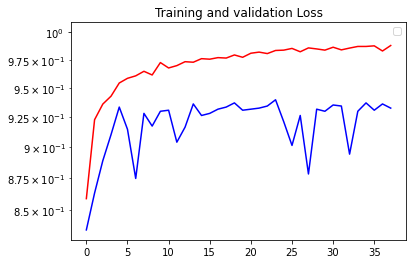

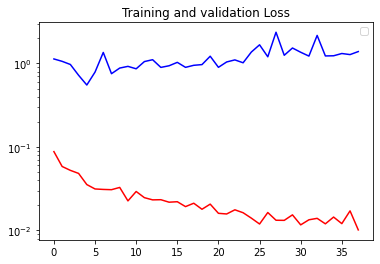

In [12]:
labels = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix for valid Set:\n========================================")
validation_generator.reset()
Y_pred = model.predict_generator(validation_generator, validation_generator.samples // batch_size+1)


y_pred = np.argmax(Y_pred, axis=1)
labels=(validation_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in y_pred]
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)
print(cf_matrix)


import seaborn as sns
plt.figure()
print('Classification Report for Valid Set')
print(classification_report(validation_generator.classes, y_pred, target_names=labels))

print("Confusion Matrix for Train Set:\n========================================")
train_generator.reset()
Y_pred_T = model.predict_generator(train_generator, (train_generator.samples // batch_size+1))
y_pred_T = np.argmax(Y_pred_T, axis=1)
cf_matrix_T = confusion_matrix(train_generator.classes, y_pred_T)
print(cf_matrix_T)



print('Classification Report for Train Set')
print(classification_report(train_generator.classes, y_pred_T, target_names=labels))
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
print(history.history.keys())
acc=history.history['categorical_accuracy']

val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# ------------------------------------------------
# Plot training and validation accuracy per epoch
# ------------------------------------------------
plt.figure()
plt.semilogy(epochs, acc, 'r', "Training Accuracy")
plt.semilogy(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation Loss')
plt.legend()
# ------------------------------------------------
# Plot training and validation accuracy per epoch
# ------------------------------------------------
plt.figure()
plt.semilogy(epochs, loss, 'r', "Loss of Training")
plt.semilogy(epochs, val_loss, 'b', "Loss of Validation")
plt.title('Training and validation Loss')
plt.legend()